#**Major Project:** Netflix Dataset Analysis
### **Goal:** Content Trends Analysis for Strategic Recommendations
## Objectives:
 - Analyze distribution of Movies vs TV Shows over the years.
 - Identify the most common genres and how their popularity changed.
 - Compare country-wise contributions to Netflix’s catalog.
## Expected outputs:
 - Time series of content added / release distribution (Movies vs TV Shows).
 - Top genres overall and by year.
 - Country-wise contribution and map / bar charts.
 - Strategic recommendations summary.


In [11]:
# Cell 2 - Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import seaborn as sns
from collections import Counter
import os
%matplotlib inline

# Set plot style (matplotlib defaults are fine; adjust if you prefer)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.grid'] = True
sns.set_context('talk')


In [12]:
# Cell 3 - Load dataset (change path if needed)
file_path = '/content/Netflix Dataset.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV file not found at {file_path}. Update file_path to your CSV location.")
df = pd.read_csv('/content/Netflix Dataset.csv')
print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (7789, 11)


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [13]:
# Cell 4 - Quick overview of columns, types, missing values
print("Columns:", df.columns.tolist())
display(df.info())
display(df.isna().sum().sort_values(ascending=False))


Columns: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB


None

,0
Director,2388
Cast,718
Country,507
Release_Date,10
Rating,7
Show_Id,0
Category,0
Title,0
Duration,0
Type,0


In [14]:
# Cell 5 - Standardize column names (common Netflix dataset variants)
# This tries to handle both 'listed_in' or 'type' naming differences
df = df.rename(columns={
    col: col.strip() for col in df.columns
})
# Common aliases
if 'listed_in' in df.columns and 'type' not in df.columns:
    df = df.rename(columns={'listed_in': 'genres'})
elif 'type' in df.columns and 'genres' not in df.columns:
    # sometimes 'type' means Movie/TV Show; if so, keep it and also check 'listed_in'
    if 'listed_in' in df.columns:
        df = df.rename(columns={'listed_in': 'genres'})
# unify Movie/TV column name -> 'category'
if 'type' in df.columns:
    df = df.rename(columns={'type': 'category'})
# Date column may be 'date_added' or 'date'
if 'date_added' not in df.columns and 'date' in df.columns:
    df = df.rename(columns={'date': 'date_added'})

print("Columns after renaming:", df.columns.tolist())


Columns after renaming: ['Show_Id', 'Category', 'Title', 'Director', 'Cast', 'Country', 'Release_Date', 'Rating', 'Duration', 'Type', 'Description']


In [15]:
# Cell 6 - Inspect key columns and common formats
sample_cols = ['category','title','director','cast','country','date_added','release_year','rating','duration','genres','description']
for c in sample_cols:
    if c in df.columns:
        print(f"\n--- {c} sample ---")
        display(df[c].dropna().sample(min(6, df[c].dropna().shape[0]), random_state=2))


In [18]:
# Cell 7 - CLEANING & FEATURE ENGINEERING (error-proof version)
# - parse date_added to datetime
# - ensure release_year numeric
# - normalize genres and countries (explode multi-valued fields)
# - extract duration numeric (for Movies: minutes, for TV Shows: seasons)

df_clean = df.copy()

# --- Standardize column names (lowercase, strip spaces) ---
df_clean.columns = df_clean.columns.str.strip().str.lower()

# --- Handle date_added or similar columns ---
date_cols = [c for c in df_clean.columns if 'date' in c]
if date_cols:
    date_col = date_cols[0]
    df_clean['date_added'] = df_clean[date_col].astype(str).str.strip().replace({'nan': np.nan, 'None': np.nan})
    df_clean['date_added_parsed'] = pd.to_datetime(df_clean['date_added'], errors='coerce', dayfirst=False)
else:
    df_clean['date_added_parsed'] = pd.NaT

# --- Handle release_year or similar columns ---
year_cols = [c for c in df_clean.columns if 'year' in c]
if year_cols:
    year_col = year_cols[0]
    df_clean['release_year'] = pd.to_numeric(df_clean[year_col], errors='coerce').astype('Int64')
else:
    df_clean['release_year'] = np.nan

# --- Normalize category/type column ---
cat_cols = [c for c in df_clean.columns if c in ['type', 'category']]
if cat_cols:
    cat_col = cat_cols[0]
    df_clean['category'] = df_clean[cat_col].astype(str).str.strip().str.title()
else:
    df_clean['category'] = 'Unknown'

# --- Normalize genres (e.g., 'listed_in') ---
if 'listed_in' in df_clean.columns:
    df_clean['genres'] = df_clean['listed_in'].fillna('').astype(str).str.strip()
elif 'genres' in df_clean.columns:
    df_clean['genres'] = df_clean['genres'].fillna('').astype(str).str.strip()
else:
    df_clean['genres'] = ''

# --- Normalize country ---
if 'country' in df_clean.columns:
    df_clean['country'] = df_clean['country'].fillna('').astype(str).str.strip()
else:
    df_clean['country'] = ''

# --- Parse duration numerically ---
def parse_duration(d):
    if pd.isna(d):
        return np.nan
    s = str(d).lower().strip()
    if 'min' in s:
        num = ''.join(ch for ch in s if ch.isdigit())
        return int(num) if num else np.nan
    elif 'season' in s:
        num = ''.join(ch for ch in s if ch.isdigit())
        return int(num) if num else 1
    else:
        try:
            return int(s)
        except:
            return np.nan

dur_cols = [c for c in df_clean.columns if 'duration' in c]
if dur_cols:
    dur_col = dur_cols[0]
    df_clean['duration_parsed'] = df_clean[dur_col].apply(parse_duration).astype('Float64')
else:
    df_clean['duration_parsed'] = np.nan

# ✅ Safely display key columns that exist
cols_to_display = [c for c in ['date_added_parsed','release_year','category','genres','country','duration_parsed'] if c in df_clean.columns]
df_clean[cols_to_display].head()


,date_added_parsed,release_year,category,genres,country,duration_parsed
0,2020-08-14,NaN,Tv Show,,Brazil,4.0
1,2016-12-23,NaN,Movie,,Mexico,93.0
2,2018-12-20,NaN,Movie,,Singapore,78.0
3,2017-11-16,NaN,Movie,,United States,80.0
4,2020-01-01,NaN,Movie,,United States,123.0


In [19]:
# Cell 8 - Create exploded dataframes for genres and countries (for counting)
# Explode genres into rows
df_genres = df_clean.copy()
# split on comma and strip
df_genres['genre_list'] = df_genres['genres'].apply(lambda x: [g.strip() for g in x.split(',')] if x else [])
df_genres = df_genres.explode('genre_list')
df_genres['genre_list'] = df_genres['genre_list'].replace('', np.nan)
df_genres = df_genres.dropna(subset=['genre_list'])  # only rows with a genre

# Explode countries
df_countries = df_clean.copy()
df_countries['country_list'] = df_countries['country'].apply(lambda x: [c.strip() for c in x.split(',')] if x else [])
df_countries = df_countries.explode('country_list')
df_countries['country_list'] = df_countries['country_list'].replace('', np.nan)
df_countries = df_countries.dropna(subset=['country_list'])

# Quick sanity counts
print("Total original rows:", df_clean.shape[0])
print("Total genre-rows (after explode):", df_genres.shape[0])
print("Total country-rows (after explode):", df_countries.shape[0])


Total original rows: 7789
Total genre-rows (after explode): 0
Total country-rows (after explode): 9065


In [20]:
# Cell 9 - Objective 1: Distribution of Movies vs TV Shows over the years
# We'll count by release_year (or date_added_parsed year as fallback)
def year_source_row(row):
    if not pd.isna(row['release_year']):
        return int(row['release_year'])
    elif not pd.isna(row['date_added_parsed']):
        return row['date_added_parsed'].year
    else:
        return np.nan

df_clean['year_for_analysis'] = df_clean.apply(year_source_row, axis=1)
df_year_cat = df_clean.dropna(subset=['year_for_analysis']).groupby(['year_for_analysis','category']).size().unstack(fill_value=0)
df_year_cat = df_year_cat.sort_index()
df_year_cat.tail(10)


category,Movie,Tv Show
year_for_analysis,,
2012.0,3,0
2013.0,6,5
2014.0,19,6
2015.0,58,30
2016.0,258,185
2017.0,864,361
2018.0,1255,430
2019.0,1498,656
2020.0,1313,697


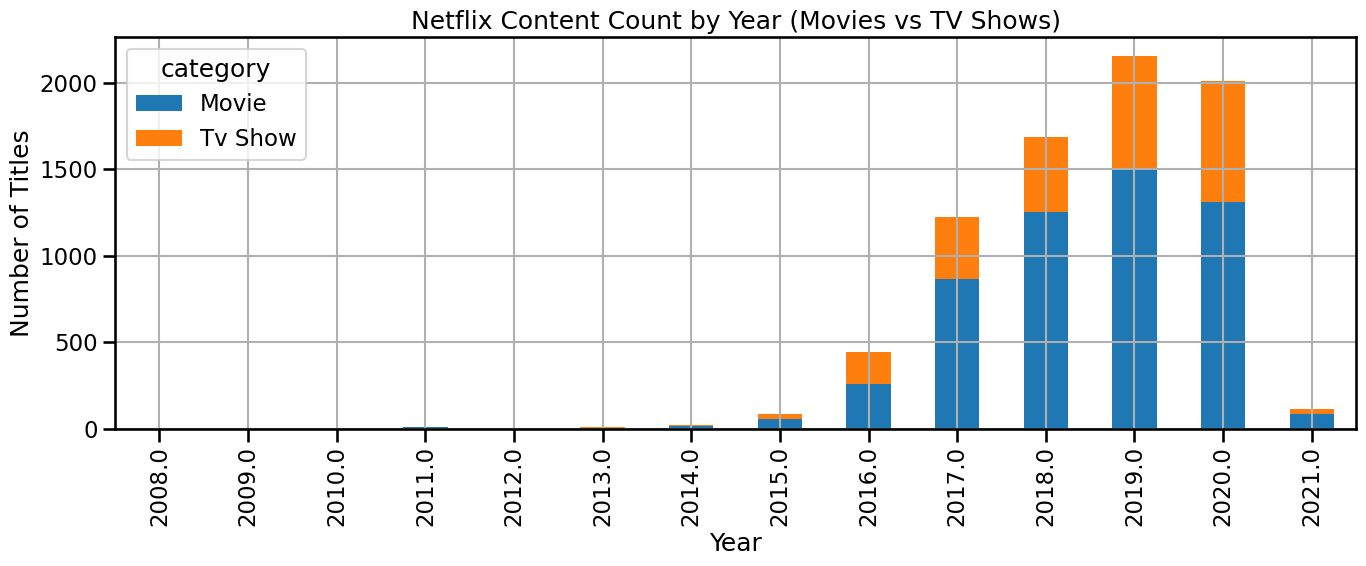

In [21]:
# Cell 10 - Plot Movies vs TV Shows by year (stacked)
ax = df_year_cat.plot(kind='bar', stacked=True, figsize=(14,6))
ax.set_title('Netflix Content Count by Year (Movies vs TV Shows)')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Titles')
plt.tight_layout()
plt.show()


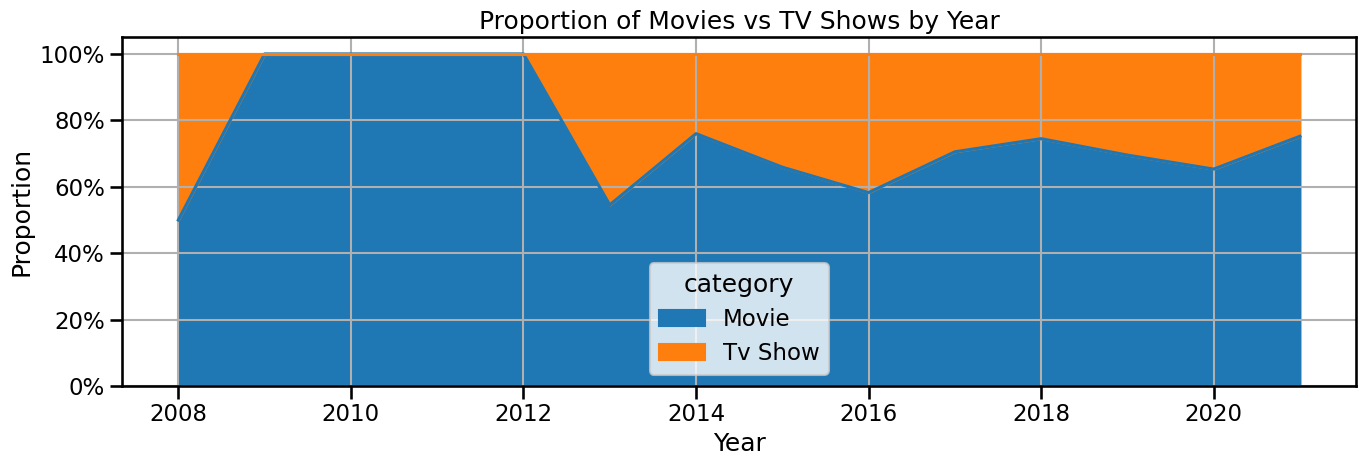

In [30]:
# Cell 11 - Relative proportions over time (percentage)
df_year_prop = df_year_cat.div(df_year_cat.sum(axis=1), axis=0).fillna(0)
ax = df_year_prop.plot(kind='area', figsize=(14,5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_title('Proportion of Movies vs TV Shows by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Proportion')
plt.tight_layout()
plt.show()


In [31]:
if 'year_for_analysis' not in df_clean.columns:
    def extract_year(row):
        if pd.notna(row.get('release_year')):
            return int(row['release_year'])
        elif pd.notna(row.get('date_added_parsed')):
            return row['date_added_parsed'].year
        return np.nan
    df_clean['year_for_analysis'] = df_clean.apply(extract_year, axis=1)

/tmp/ipython-input-226858579.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='rating', data=df_clean, order=df_clean['rating'].value_counts().index, palette="viridis")


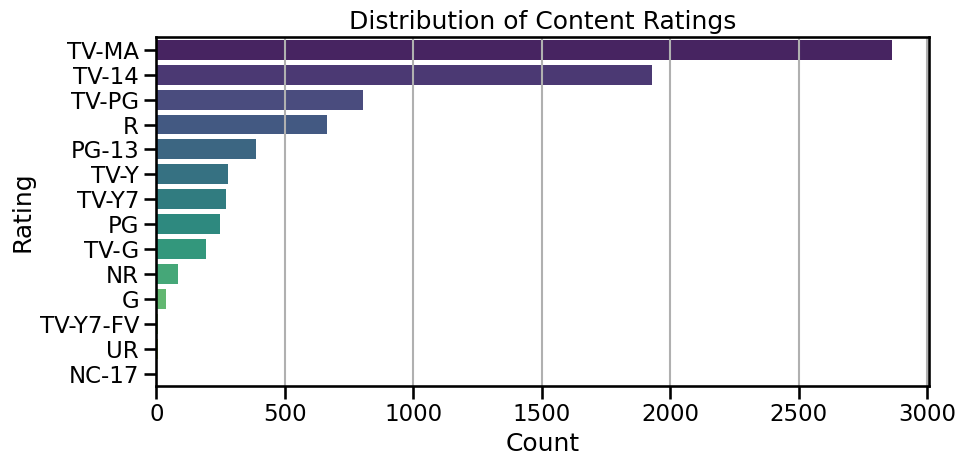

In [33]:
if 'rating' in df_clean.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(y='rating', data=df_clean, order=df_clean['rating'].value_counts().index, palette="viridis")
    plt.title("Distribution of Content Ratings")
    plt.xlabel("Count")
    plt.ylabel("Rating")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-951648313.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")


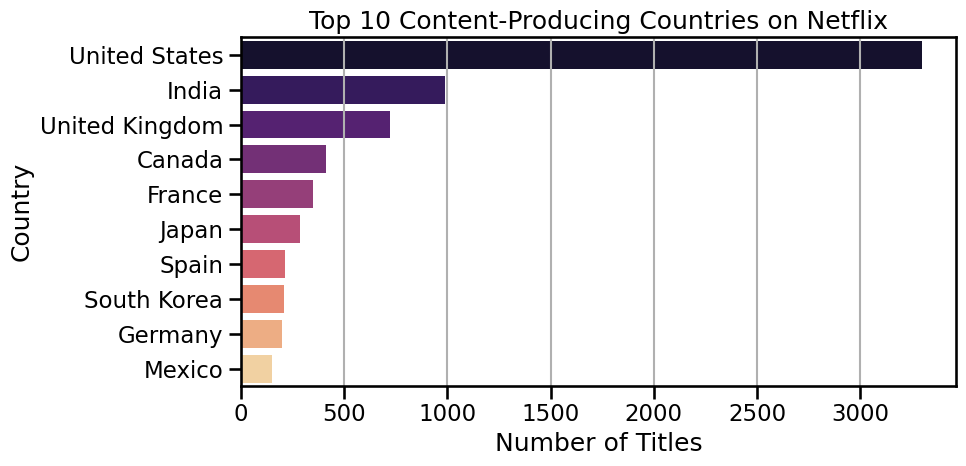

In [34]:
df_country = df_clean.copy()
df_country['country_list'] = df_country['country'].fillna('').astype(str).apply(
    lambda x: [c.strip() for c in x.split(',') if c.strip()]
)
df_country = df_country.explode('country_list').dropna(subset=['country_list'])

top_countries = df_country['country_list'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="magma")
plt.title("Top 10 Content-Producing Countries on Netflix")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


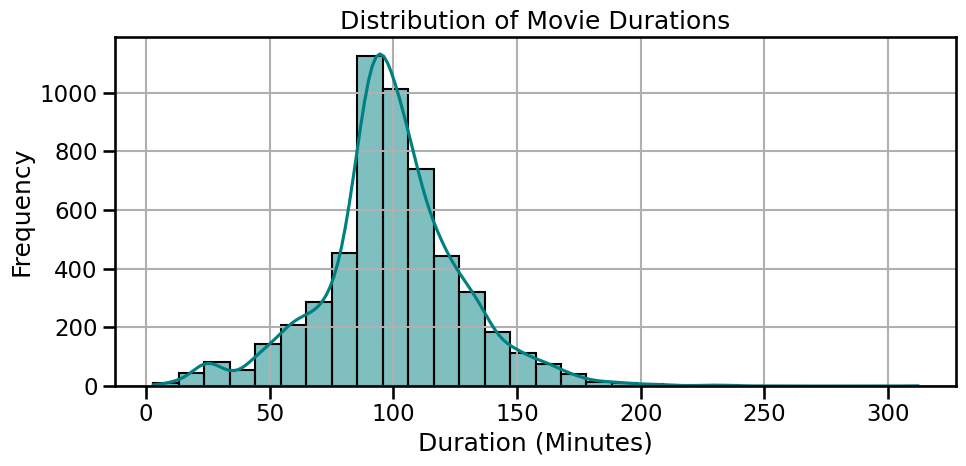

In [35]:
if 'category' in df_clean.columns and 'duration_parsed' in df_clean.columns:
    movie_durations = df_clean[df_clean['category'].str.contains("Movie", case=False, na=False)]

    plt.figure(figsize=(10, 5))
    sns.histplot(movie_durations['duration_parsed'].dropna(), bins=30, kde=True, color='teal')
    plt.title("Distribution of Movie Durations")
    plt.xlabel("Duration (Minutes)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3715515398.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='duration_parsed', data=tv_shows, palette="plasma")


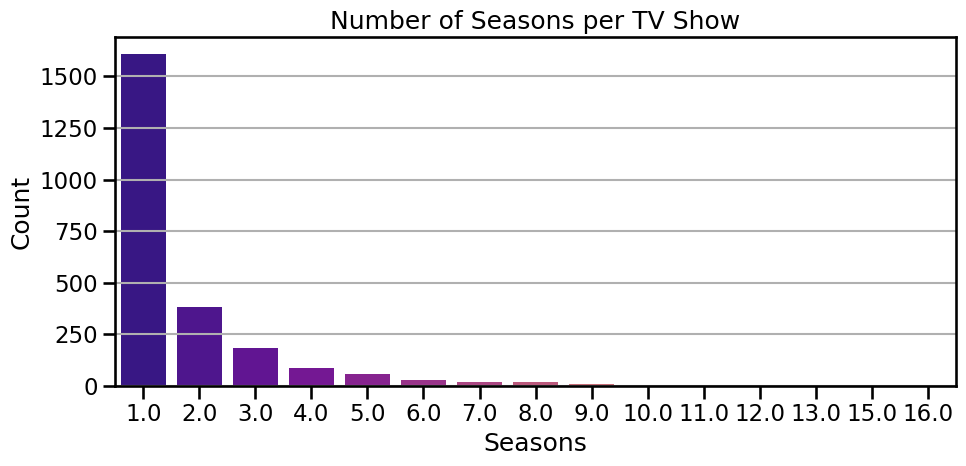

In [36]:
tv_shows = df_clean[df_clean['category'].str.contains("TV", case=False, na=False)]

plt.figure(figsize=(10, 5))
sns.countplot(x='duration_parsed', data=tv_shows, palette="plasma")
plt.title("Number of Seasons per TV Show")
plt.xlabel("Seasons")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

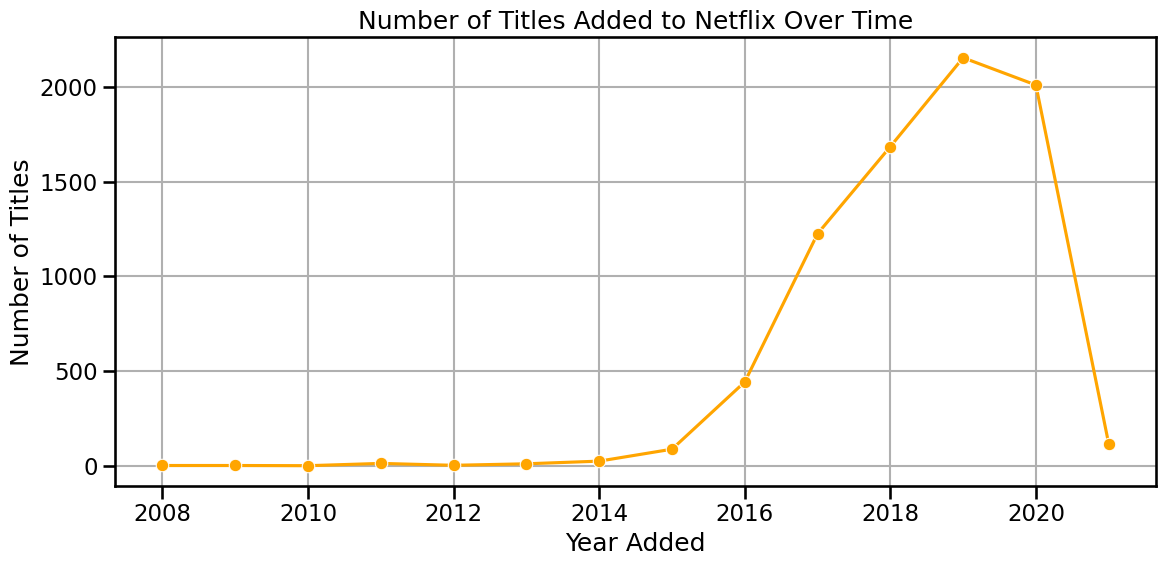

In [37]:
if 'date_added_parsed' in df_clean.columns:
    df_by_year = df_clean.copy()
    df_by_year['year_added'] = df_by_year['date_added_parsed'].dt.year
    added_per_year = df_by_year['year_added'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=added_per_year.index, y=added_per_year.values, marker='o', color='orange')
    plt.title("Number of Titles Added to Netflix Over Time")
    plt.xlabel("Year Added")
    plt.ylabel("Number of Titles")
    plt.tight_layout()
    plt.show()